In [1]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn import metrics
import numpy as np
import pandas as pd

from sklearn.naive_bayes import MultinomialNB # import naive bayes
from sklearn.tree import DecisionTreeClassifier # import Decision Tree
from sklearn.ensemble import RandomForestClassifier # import random forest

# Using Pandas to read the 3 data files

In [2]:
#using Pandas to read the 3 files 
true = pd.read_csv('True.csv')
fake = pd.read_csv('Fake.csv')
ai = pd.read_excel('AI.xlsx')

In [3]:
#assigning lables for each class 
# fake = 0
#true = 1
#AI = 2
fake['label'] = 0
true['label'] = 1
ai['label'] = 2


In [4]:
#dropping the subject and date columns from the true and fake data frames
fake = fake.drop(['subject', 'date'], axis=1)
true = true.drop(['subject', 'date'], axis=1)


In [5]:
#merging the 3 data frames
merged_df = pd.concat([true, fake,ai])

In [6]:
#combining the title and text columns
merged_df['Combined text'] = merged_df['title'] + merged_df['text']

In [7]:
#creating a final Df using the merged Df 
final_df = merged_df.copy()

In [8]:
#droppping the title and text column
final_df = final_df.drop(['title', 'text'], axis=1)

In [9]:
#Getting the 'Combined text' column to the first position in final df
first_column = final_df.pop('Combined text')
final_df.insert(0,'Combined text', first_column)
final_df = final_df.reset_index(drop=True)
final_df['Combined text'] = final_df['Combined text'].astype('str') 


# Defining two functions to Count number of paragraphs and length of article 

In [10]:
# Define a function to count paragraphs in a text
def count_paragraphs(text):
    return text.count('\n\n') + 1

# Define a function to calculate the length of a text (in words)
def calculate_length(text):
    words = nltk.word_tokenize(text)
    return len(words)

## Count of paragraphs and average length of article by class

In [11]:
data = pd.DataFrame()
data['label'] = final_df['label']
data['Text'] = final_df['Combined text']

# Apply the functions to the DataFrame
data['num_paragraphs'] = final_df['Combined text'].apply(count_paragraphs)
data['article_length'] = final_df['Combined text'].apply(calculate_length)

# Group by label and calculate the average article length and number of paragraphs
grouped = data.groupby('label').agg({
    'num_paragraphs': 'mean',
    'article_length': 'mean'
})

# Print the results
print(grouped)

       num_paragraphs  article_length
label                                
0                 1.0      485.438505
1                 1.0      445.139235
2                 1.0       54.982867


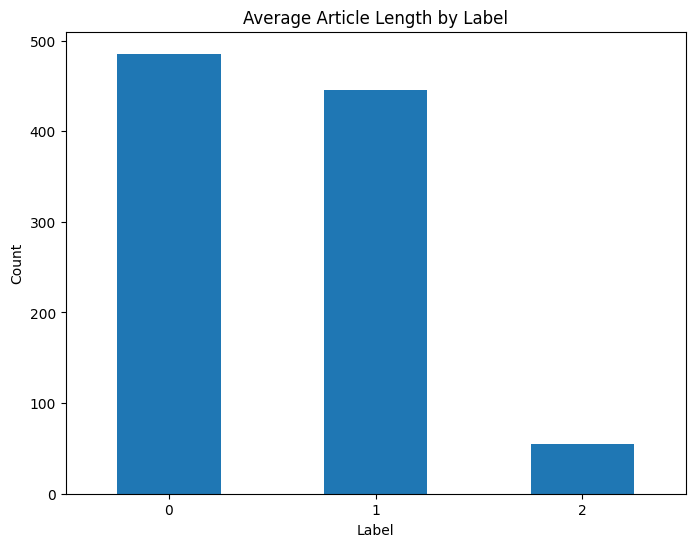

In [12]:
# Bar chart to display the Average article length by Label
# Use the plot() method to create a bar chart
grouped['article_length'].plot(kind='bar', figsize=(8, 6))

# Add a title and axis labels
plt.title('Average Article Length by Label')
plt.xlabel('Label')
plt.xticks(rotation=0)
plt.ylabel('Count')

# Show the plot
plt.show()


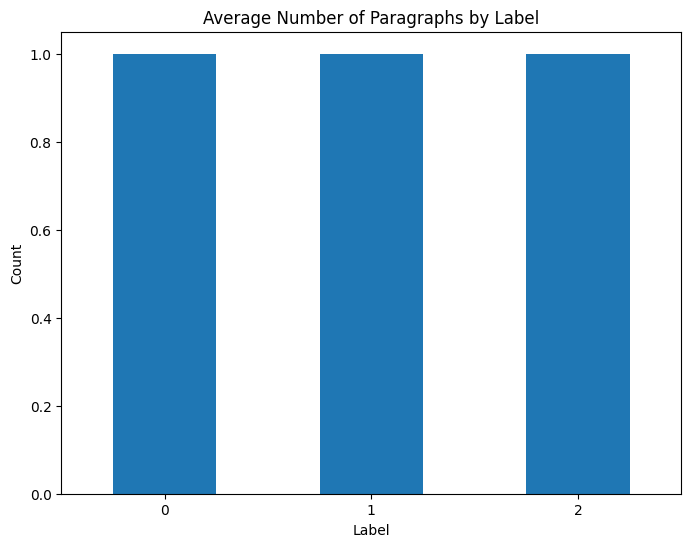

In [13]:
# Bar chart to display the Average Number of Paragraphs by Labels
# Use the plot() method to create a bar chart
grouped['num_paragraphs'].plot(kind='bar', figsize=(8, 6))

# Add a title and axis labels
plt.title('Average Number of Paragraphs by Label')
plt.xlabel('Label')
plt.xticks(rotation=0)
plt.ylabel('Count')

# Show the plot
plt.show()

# Pre-processing

In [14]:
mystopwords = stopwords.words('english')
#extending the stop words to include specific words 
new_stopwords = ['Copyright',  'washington', 'reuters', 'seattle']
mystopwords.extend(new_stopwords)

In [15]:
#removing non alphabets
remove_non_alphabets = lambda x: re.sub(r'[^a-zA-Z]',' ',x)
#removing stop words
remove_stopwords = lambda text: ' '.join(word for word in text.split() if word not in mystopwords)
#tokenizing
tokenize = lambda x: word_tokenize(x)
#removing punctuation
remove_punctuation = lambda text: text.translate(str.maketrans('', '', string.punctuation))
# stemming
ps = PorterStemmer()
stem = lambda w: [ ps.stem(x) for x in w ]
# lemmatization
lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [ lemmatizer.lemmatize(word) for word in x ]

In [16]:
# apply all the methods above to the column Message
print('Processing : [=', end='')
final_df['Combined text'] = final_df['Combined text'].apply(remove_non_alphabets)
print('=', end='')
final_df['Combined text'] = final_df['Combined text'].apply(remove_stopwords)
print('=', end='')
final_df['Combined text'] = final_df['Combined text'].apply(remove_punctuation)
print('=', end='')
final_df['Combined text'] = final_df['Combined text'].apply(tokenize)
print('=', end='')
final_df['Combined text'] = final_df['Combined text'].apply(stem)
print('=', end='')
final_df['Combined text'] = final_df['Combined text'].apply(leammtizer)
print('=', end='')
final_df['Combined text'] = final_df['Combined text'].apply(lambda x: ' '.join(x))
print('] : Completed', end='')

Processing : [=======] : Completed

In [17]:
# displaying the final df after pre-processing
final_df

,Combined text,label
0,a u s budget fight loom republican flip fiscal...,1
1,u s militari accept transgend recruit monday p...,1
2,senior u s republican senat let mr mueller job...,1
3,fbi russia probe help australian diplomat tip ...,1
4,trump want postal servic charg much amazon shi...,1
...,...,...
46019,u suprem court uphold afford care actth u supr...,2
46020,japan announc plan releas treat fukushima wate...,2
46021,global semiconductor shortag threaten auto ind...,2
46022,canada introduc new gun control legislationcan...,2


## Average Count number of paragraphs and length of article after pre-processing

In [18]:
data = pd.DataFrame()
data['label'] = final_df['label']
data['Text'] = final_df['Combined text']

# Apply the functions to the DataFrame
data['num_paragraphs'] = final_df['Combined text'].apply(count_paragraphs)
data['article_length'] = final_df['Combined text'].apply(calculate_length)

# Group by label and calculate the average article length and number of paragraphs
grouped = data.groupby('label').agg({
    'num_paragraphs': 'mean',
    'article_length': 'mean'
})

# Print the results
print(grouped)


       num_paragraphs  article_length
label                                
0                 1.0      268.340455
1                 1.0      248.473269
2                 1.0       33.544635


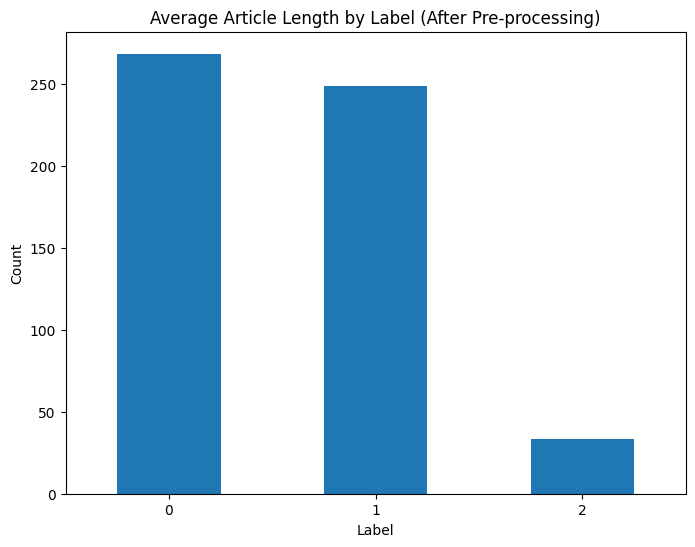

In [19]:
# Bar chart to display the Average article length by Label
# Use the plot() method to create a bar chart
grouped['article_length'].plot(kind='bar', figsize=(8, 6))

# Add a title and axis labels
plt.title('Average Article Length by Label (After Pre-processing)')
plt.xlabel('Label')
plt.xticks(rotation=0)
plt.ylabel('Count')

# Show the plot
plt.show()


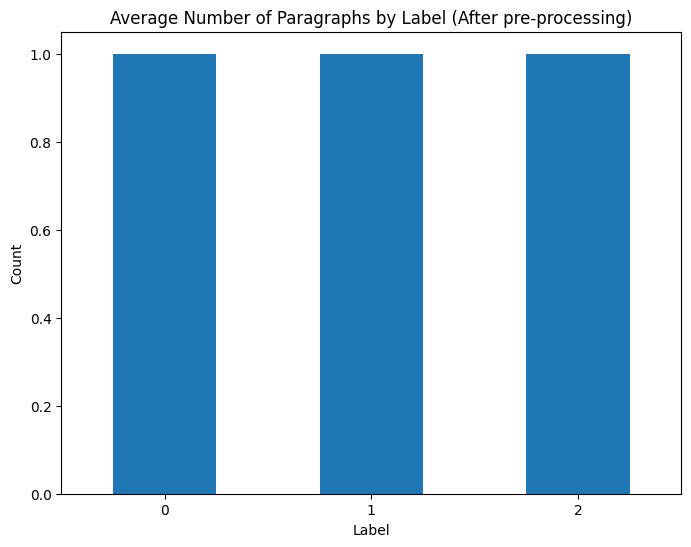

In [20]:
# Bar chart to display the Average Number of Paragraphs by Labels
# Use the plot() method to create a bar chart
grouped['num_paragraphs'].plot(kind='bar', figsize=(8, 6))

# Add a title and axis labels
plt.title('Average Number of Paragraphs by Label (After pre-processing)')
plt.xlabel('Label')
plt.xticks(rotation=0)
plt.ylabel('Count')

# Show the plot
plt.show()

# Splitting Data into train test using a 70-30 split

In [21]:
train_corpus, test_corpus, train_labels, test_labels = train_test_split(final_df["Combined text"],
                                                                        final_df["label"],
                                                                        test_size=0.3)

# Vectorizing the Train and test corpus using Tf-idf

In [22]:
tfidf_vectorizer=TfidfVectorizer(min_df=1, 
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=(1,1))
tfidf_train_features = tfidf_vectorizer.fit_transform(train_corpus)  
tfidf_test_features = tfidf_vectorizer.transform(test_corpus)

In [23]:
tfidf_train = tfidf_vectorizer.fit_transform(final_df["Combined text"])

# Defining a fucntion to train, test and get a confusion matrix 

In [24]:
def train_predict_evaluate_model(classifier, 
                                 train_features, train_labels, 
                                 test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    # evaluate model prediction performance   

    print(metrics.classification_report(test_labels,predictions))

    #confusion matrix
    cm = confusion_matrix(test_labels, predictions, labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot(cmap='Blues') 
    plt.show() 
    return predictions, metrics.accuracy_score(test_labels,predictions)  

# Machine Leanring Models

In [25]:
mnb = MultinomialNB()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(criterion="entropy")

## MultinomialNB

c:\Users\parth\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\parth\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\parth\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7056
           1       0.92      0.92      0.92      6426
           2       0.00      0.00      0.00       326

    accuracy                           0.92     13808
   macro avg       0.61      0.63      0.62     13808
weighted avg       0.90      0.92      0.91     13808



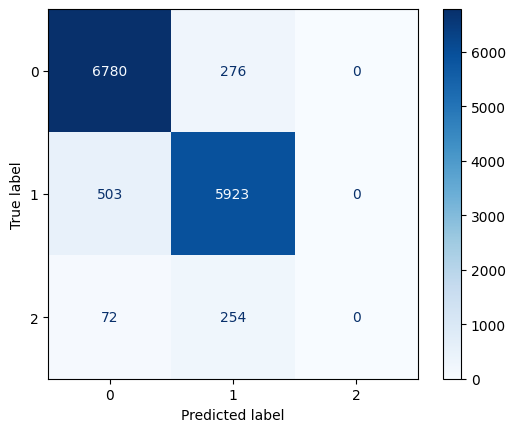

In [26]:
# predict and evaluate naive bayes
mnb_tfidf_predictions, mnb_tfidf_accuracy = train_predict_evaluate_model(classifier=mnb,
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)

### Average 10 Fold Validation score

In [27]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(mnb, tfidf_train, final_df["label"], cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.918 (0.005)


## Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7056
           1       1.00      0.99      1.00      6426
           2       0.84      0.90      0.87       326

    accuracy                           0.99     13808
   macro avg       0.94      0.96      0.95     13808
weighted avg       0.99      0.99      0.99     13808



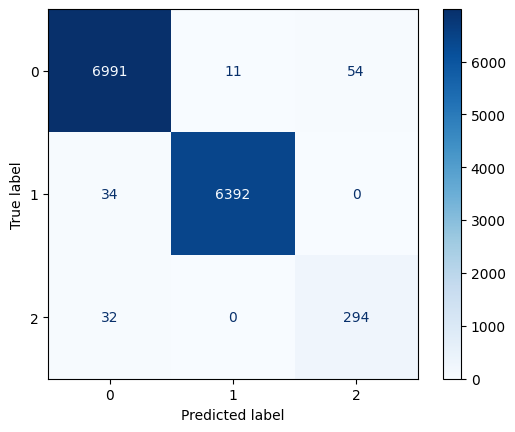

In [28]:
# predict and evaluate decision tree
dt_tfidf_predictions, dt_tfidf_accuracy = train_predict_evaluate_model(classifier=dt,
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)

### Average 10 Fold Validation score

In [29]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(dt, tfidf_train, final_df["label"], cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.991 (0.001)


## Random Forest 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7056
           1       1.00      0.99      0.99      6426
           2       1.00      0.95      0.98       326

    accuracy                           0.99     13808
   macro avg       1.00      0.98      0.99     13808
weighted avg       0.99      0.99      0.99     13808



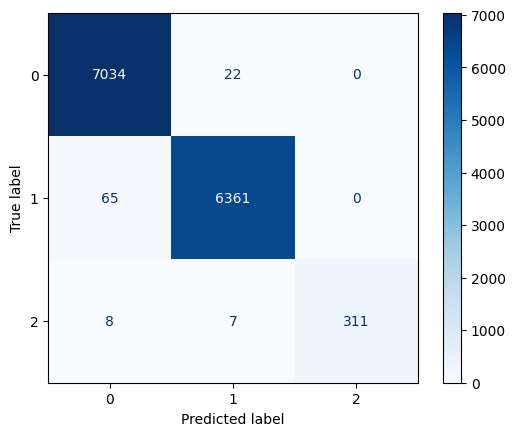

In [30]:
# predict and evaluate random forest
rf_tfidf_predictions, rf_tfidf_accuracy = train_predict_evaluate_model(classifier=rf,
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)

### Average 10 Fold Validation score

In [31]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(rf, tfidf_train, final_df["label"], cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.992 (0.001)
